In [1]:
# Import our dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot

# 1. Load Data

In [2]:
# Import our input dataset
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header = None, delim_whitespace = True)
    return dataframe.values

fitbit_df = load_file('Resources/train/Inertial Signals/total_acc_y_train.txt')
print(fitbit_df.shape)

(7352, 128)


* Working with multivariate time series data, it is useful to have the data structured in the format:
       [samples, timesteps, features]
* Once loaded each file as a NumPy array, then combine or stack all three arrays together. 
* Use the dstack() NumPy function to ensure each array is stacked in a way that the features are separated in the third dimension

In [3]:
#load list of files, x,y,z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    #stack group
    loaded = np.dstack(loaded)
    return loaded

# load all of total acceleration files
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix = "Resources/train/Inertial Signals/")
print(total_acc.shape)

(7352, 128, 3)


## Use the two functions to load all data for the train and the test dataset.
* develop a new function that loads all input and output data for a given folder
* function builds a list of all 9 data files to load and loads them as one NumPy array with 9 features
* next load the data file containing the output class

#### Results
* load the train and test datasets
* test dataset has 2,947 rows of window data. 
* the size of windows in the train and test sets match and the size of the output (y) in each the train and test case matches the number of samples

In [8]:
# load dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    
    # load all 9 files as a single array
    filenames = list()

    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']

    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    # load input data
    X = load_group(filenames, filepath)

    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load all train
trainX, trainy = load_dataset('train', 'Resources/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', 'Resources/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


# 2. Balance of Activity Classes

* good first check of data is to investigate the balance of each activity.
* 30 subjects performed each of the six activities. Confirming this expectation will both check that the data is balanced, making it easier to model, and confirm that the dataset is being loaded and interpreted properly.
* will develop a function that summarizes the breakdown of the output variables
* wrapp the provided NumPy array in a DataFrame, group the rows by the class value, and calculate the size of each group (number of rows). 
* results are summarized, including the count and the percentage.

#### Results
* it summarizes the breakdown for the training set. 
* similar distribution of each class hovering between 13% and 19% of the dataset.
* result on the test set and on both datasets together look very similar.
* likely safe to work with the dataset assuming distribution of classes is balanced per train and test set

In [9]:
# summarize  the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    
    #group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    
    # retrieve raw rows
    counts = counts.values
    
    #summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))
        
# load train file
trainy = load_file('Resources/train/y_train.txt')
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)
 
# load test file
testy = load_file('Resources/test/y_test.txt')
# summarize class breakdown
print('Test Dataset')
class_breakdown(testy)
 
# summarize combined class breakdown
print('Both')
combined = np.vstack((trainy, testy))
class_breakdown(combined)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222
Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


# 3. Plot Time Series Data for One Subject

* time series data
* an import check: create a line plot of the raw data.
* The raw data is comprised of windows of time series data per variable, and the windows do have a 50% overlap. 
* may see repetition in the observations as a line plot unless the overlap is removed.

#### First
* Retrieve all of the rows for a single subject
* take the loaded training data, the loaded mapping of row number to subjects, and the subject identification number for the subject interested in, and return the X and y data for only that subject.

#### Second
* data for one subject plot it.
* write a function to remove data overlap and shrink windows down for given variable into one long sequence which can be plotted directly as a line plot.

#### Final

* plot each of the nine variables for the subject in turn
* a final plot for the activity level.
* Each series will have the same number of time steps (length of x-axis)

#### Results
* periods of large movement corresponding with activities 1, 2, and 3: the walking activities
* much less activity (i.e. relatively straight line) for higher numbered activities, 4, 5, and 6 (sitting, standing, and laying).
* good confirmation that the dataset has been correctly loaded and interpreted.
* see a lot of commonality across the nine variables so very likely that only a subset of these traces are needed to develop a predictive model.
* will find other subjects show similar behavior given that they performed the same actions.

In [21]:
# load data
trainX, trainy = load_dataset('train', 'Resources/')

# retrieve a list of the unique subjects in the training dataset
sub_map = load_file('Resources/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [22]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

In [23]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove overlap from the window
        half = int(len(window) /2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


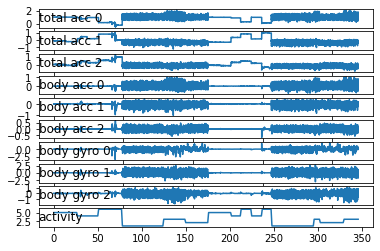

In [24]:
# plot the data for one subject
def plot_subject(X, y):
    pyplot.figure()
    
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('total acc '+str(i), y=0, loc='left')
        off += 1
    
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body acc '+str(i), y=0, loc='left')
        off += 1
    
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y)
    pyplot.title('activity', y=0, loc='left')
    pyplot.show()
    
# load data
trainX, trainy = load_dataset('train', 'Resources/')

# load mapping of rows to subjects
sub_map = load_file('Resources/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)

print(subX.shape, suby.shape)

# plot data for subject
plot_subject(subX, suby)

# 4. Plot Histograms Per Subject

* regularity in movement data across subjects
* data has been scaled between -1 and 1, per subject, so the amplitude of detected movements will be similar.
* check for similarity of behavior across subjects by plotting and comparing the histograms of movement data across subjects. 
* create one plot per subject and plot all three axis of a given data, then repeat this for multiple subjects.

#### Results
* some of the distributions align (e.g. main groups in the middle around 0.0), so there may be some continuity of movement data across subjects
* strong consistency across subjects could later help for the modeling
* differences across subjects in total acceleration data may not be as helpful.

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


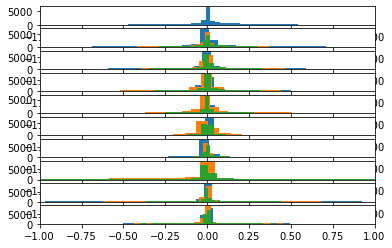

In [28]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
    pyplot.figure()
    
    # get unique subjects
    subject_ids = np.unique(sub_map[:,0])

    # enumerate subjects
    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]

        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)

        # body acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(subX[:,:,6+i]), bins=100)
    pyplot.show()
    
# load training dataset
X, y = load_dataset('train', 'Resources/')
# load mapping of rows to subjects
sub_map = load_file('resources/train/subject_train.txt')
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)

# 5. Plot Histograms Per Activity

* interested in discriminating between activities based on activity data.
* discriminate between activities for a single subject. 
* review the distribution of movement data for a subject by activity.
* create a histogram plot per activity, with the three axis of a given data type on each plot. 
* expect to see differences in the distributions across activities down the plots.

#### Results
* each activity has a different data distribution, with a marked difference between the large movement (first three activities) with the stationary activities (last three activities). 
* Data distributions for the first three activities look Gaussian 
* Distributions for the latter activities look multi-modal (i.e. multiple peaks).
* creates plots with the similar pattern as the body acceleration data, although shows perhaps fat-tailed Gaussian-like distributions instead of bimodal distributions for the in-motion activities.
* would expect to see similar distributions and relationships for the movement data across activities for other subjects.

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


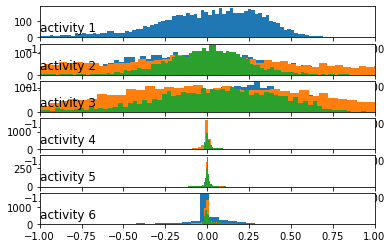

In [31]:
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):

    # get a list of unique activities for the subject
    activity_ids = np. unique(y[:,0])

    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)

    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]

        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,6+i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

# load data
trainX, trainy = load_dataset('train', 'Resources/')
# load mapping of rows to subjects
sub_map = load_file('Resources/train/subject_train.txt')
train_subjects = np.unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
plot_activity_histograms(subX, suby)

# 6. Plot Activity Duration Boxplots

* final area to consider is how long a subject spends on each activity.
* related to the balance of classes. 
* If activities (classes) are balanced within dataset, then expect balance of activities for a given subject over course of their trace would be reasonably well balanced.
* confirm this by calculating how long (in samples or rows) each subject spends on each activity 
* look at distribution of durations for each activity.
* summarize the distributions as boxplots: create a boxplot per activity of the duration measurements.

#### Results
* Shows a similar relationship between activities.
* suggests that the test and training dataset are reasonably representative of the whole dataset.

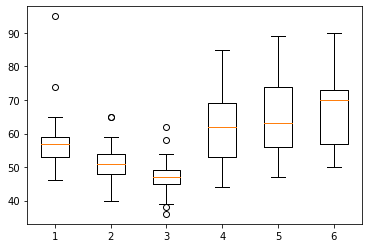

In [34]:
# plot activity durations by subject
def plot_activity_durations_by_subject(X, y, sub_map):

    # get unique subjects and activities
    subject_ids = np.unique(sub_map[:,0])
    activity_ids = np.unique(y[:,0])

    # enumerate subjects
    activity_windows = {a:list() for a in activity_ids}
    for sub_id in subject_ids:

        # get data for one subject
        _, subj_y = data_for_subject(X, y, sub_map, sub_id)

        # count windows by activity
        for a in activity_ids:
            activity_windows[a].append(len(subj_y[subj_y[:,0]==a]))
    
    # organize durations into a list of lists
    durations = [activity_windows[a] for a in activity_ids]
    pyplot.boxplot(durations, labels=activity_ids)
    pyplot.show()
    
# load training dataset
X, y = load_dataset('train', 'Resources/')
# load mapping of rows to subjects
sub_map = load_file('Resources/train/subject_train.txt')
# plot durations
plot_activity_durations_by_subject(X, y, sub_map)


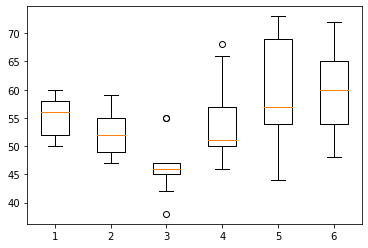

In [36]:
# With Testing
# load test dataset
X, y = load_dataset('test', 'Resources/')
# load mapping of rows to subjects
sub_map = load_file('Resources/test/subject_test.txt')
# plot durations
plot_activity_durations_by_subject(X, y, sub_map)